In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False
import matplotlib.pyplot as plt
import copy
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
from pathlib import Path

In [4]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from utils.utils import *
from utils.plotting import *
from utils.classification import *
from utils.clustering import *

# Set palette

Stating color palette for TME subtypes
- IE - Immune-Enriched
- BI - B-cell Inflamed
- D - Immune Depleted
- Mes - Mesenchymal
- F - Fibrotic

<Axes: >

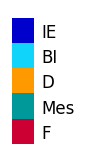

In [7]:
portrait_palette = {'IE': '#0000CC', 'BI': '#11D4FA', 'D': '#FF9900', 'Mes': '#009999', 'F': '#CC0033'}
portrait_order = ['IE', 'BI', 'D', 'Mes', 'F']
patch_plot(portrait_palette, order=portrait_order)

# Signatures

In [8]:
signatures = read_gene_sets('./genesets/stad_processes.gmt')

In [9]:
used_processes = ['Angiogenesis',
 'CAF',
 'Neutrophil_signature',
 'Protumor_cytokines',
 'MDSC',
 'M2_signature',
 'M1_signatures',
 'Coactivation_molecules',
 'Antitumor_cytokines',
 'MHCII',
 'Treg',
 'Effector_cells',
 'T_cells',
 'NK_cells',
 'Checkpoint_inhibition',
 'T_cell_traffic',
 'MHCI',
 'B_cells',
 'Lgr5_ISC',
 'Proliferation_rate']

# Meta cohort

In [10]:
meta_ann = read_dataset ('datasets/meta_annotation.tsv')
meta_ann.head()

,Lauren,Stage,ACRG_subtype,TCGA_subtype,MSI,Response,Cohort,Batch,MFP
GSM387954,Intestinal,III,EMT,NaN,NaN,NaN,Singapore_b1,1.0,Mes
GSM387921,Intestinal,IV,MSS/TP53-,NaN,NaN,NaN,Singapore_b1,1.0,IE
GSM387803,Intestinal,IV,MSS/TP53-,NaN,NaN,NaN,Singapore_b1,1.0,D
GSM387894,Intestinal,I,MSS/TP53+,NaN,NaN,NaN,Singapore_b1,1.0,D
GSM387944,Intestinal,III,MSI,NaN,NaN,NaN,Singapore_b1,1.0,IE


For the analysis processes were median-scaled 

In [11]:
meta_processes = read_dataset ('datasets/meta_processes.tsv')
meta_processes.head()

,MHCI,MHCII,Coactivation_molecules,Effector_cells,T_cell_traffic,NK_cells,T_cells,B_cells,M1_signatures,Th1_signature,...,Protumor_cytokines,CAF,Angiogenesis,Proliferation_rate,Tumor_suppressors,Oncogenes,Lgr5_ISC,MYC_targets_2,Th17_signature,Gd_T_cells
GSM387987,-0.797391,-3.379702,-0.580611,-0.983551,-0.856231,-1.341847,-1.530788,-0.620516,-0.694806,-1.352148,...,-0.958966,-0.864471,-1.010464,1.037356,-2.213833,1.706426,0.355764,1.280444,-2.139403,-1.200640
GSM387874,0.368826,-0.555909,-0.081057,-0.781857,1.286115,-0.642484,-0.769939,-0.522193,1.737255,-0.765527,...,1.741366,2.006179,2.078698,0.082655,-0.636916,-0.240635,0.794016,-0.411573,-0.349523,-0.841910
GSM387885,1.747815,0.855763,1.710360,0.297881,0.146203,-1.186227,2.735936,3.571148,-1.813091,1.206910,...,-1.075269,-0.900645,0.590437,-0.585153,-0.104226,-0.499801,-0.304246,-0.479002,0.522142,0.836776
GSM387944,0.026105,-0.356906,-0.040031,0.098563,-0.352200,-0.480144,0.211587,2.005137,0.702522,-0.688846,...,-1.229653,-1.314329,-1.736401,0.167073,0.012733,0.972244,-1.249673,0.868162,0.698835,0.065882
GSM387955,-0.425288,-2.143680,-0.988014,-0.646225,-0.695411,-0.831961,-0.939463,-0.778309,0.357263,-1.629337,...,0.268852,0.197353,0.165451,0.401882,-0.024653,1.561841,0.264432,1.106578,-0.619282,-0.775246


PCA-plot for all samples from Meta-cohort colored by TME subtype

<Axes: xlabel='PCA 1 component 39% variance explained', ylabel='PCA 2 component 12% variance explained'>

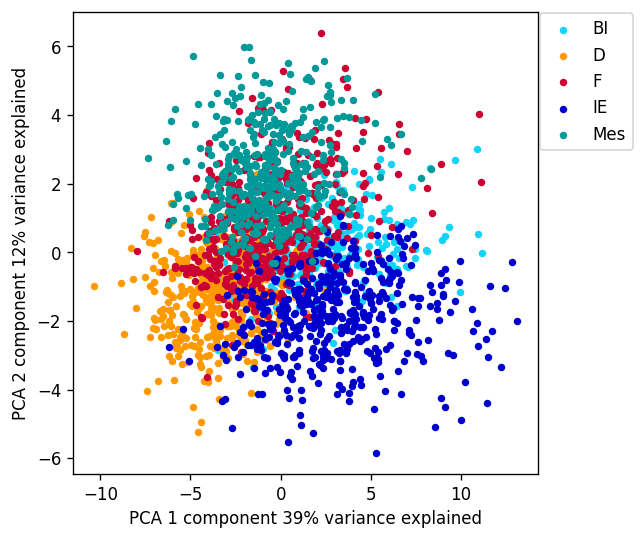

In [12]:
pca_plot(meta_processes.dropna(), meta_ann.MFP.dropna(), 
         palette=portrait_palette, legend='out')

# Classification example

For example we will use data from PUB_Kim_GSE113255 cohort. 

Publication - https://pubmed.ncbi.nlm.nih.gov/31773340/

In [13]:
ann = read_dataset('datasets/annotation.tsv')
ann.head()

,Sample,Diagnosis,Age,Lauren,Gender,Histologic_type,Cohort,Batch,Stage,MFP
SRR7014347,GSM3101117,STAD,25,Diffuse,F,mucinous adenocarcinoma,PUB_Kim_GSE113255,1,NaN,BI
SRR7014315,GSM3101085,STAD,46,Diffuse,M,poorly cohesive carcinoma,PUB_Kim_GSE113255,1,NaN,BI
SRR7014339,GSM3101109,STAD,75,Diffuse,M,poorly cohesive carcinoma,PUB_Kim_GSE113255,1,NaN,F
SRR7014400,GSM3101170,STAD,66,Diffuse,F,poorly cohesive carcinoma,PUB_Kim_GSE113255,1,NaN,BI
SRR7014379,GSM3101149,STAD,44,Diffuse,F,poorly cohesive carcinoma,PUB_Kim_GSE113255,1,NaN,IE


Reading expressions

In [14]:
# this data is already log2(1+x) transformed
exp = read_dataset('datasets/expressions.tsv.gz')
exp.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
SRR7014347,0.0,2.807852,9.313779,0.508108,0.000000,4.187848,2.124979,4.060809,3.838871,4.729745,...,4.757559,1.933892,2.591169,3.373300,0.895374,4.013479,6.057475,4.102030,4.507521,5.132591
SRR7014315,0.0,3.942764,7.738670,0.117185,0.083495,2.430373,4.719449,4.268133,4.703398,4.773175,...,4.585391,1.679657,2.296246,2.898178,0.486024,3.524278,5.301990,4.389735,4.247995,3.730085
SRR7014339,0.0,3.813112,9.441728,0.206709,0.160730,4.288434,2.528881,4.517914,3.998874,6.918425,...,5.079931,1.962928,2.559070,3.143223,0.341680,3.837767,6.341689,4.060642,3.854314,5.197480
SRR7014400,0.0,3.666326,9.745221,0.241566,0.000000,4.027291,4.403708,4.731523,4.094449,4.739757,...,4.906805,1.992885,2.148336,3.563815,0.368991,3.978450,6.601983,4.423499,4.166719,4.933166
SRR7014379,0.0,3.811508,8.015600,0.317398,0.125466,3.224220,3.729573,4.643734,3.857621,2.887837,...,5.654600,1.885077,2.603677,3.603271,0.225418,3.395305,6.396561,4.064154,4.299005,4.327262


Checking RNAseq distribution

<Axes: ylabel='Density'>

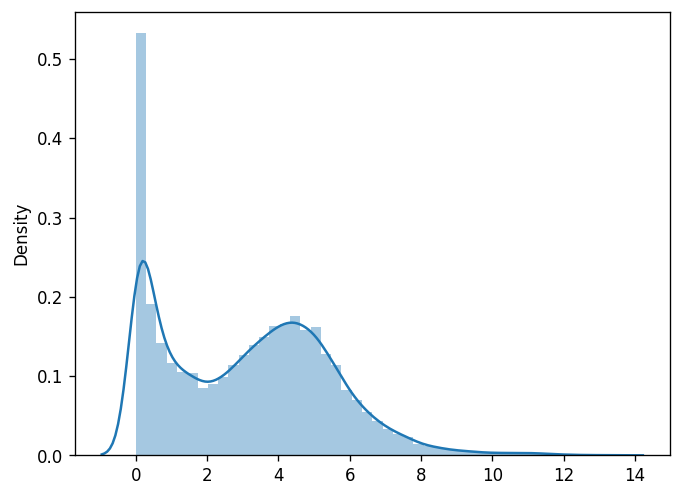

In [15]:
sns.distplot(exp.mean())

Checking batches

<Axes: xlabel='PCA 1 component 21% variance explained', ylabel='PCA 2 component 10% variance explained'>

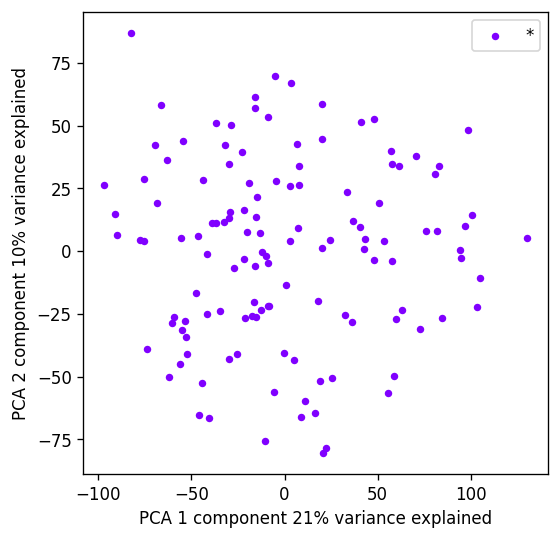

In [16]:
pca_plot(exp)

The data doesn't have batches, but if it has one, batches should be scaled separately.  

# Calculate signatures

In [17]:
proc = ssgsea_formula(exp.T, signatures)
proc_sc = median_scale(proc, clip=4)

In [18]:
proc_sc.head()

,MHCI,MHCII,Coactivation_molecules,Effector_cells,T_cell_traffic,NK_cells,T_cells,B_cells,M1_signatures,Th1_signature,...,Protumor_cytokines,CAF,Angiogenesis,Proliferation_rate,Tumor_suppressors,Oncogenes,Lgr5_ISC,MYC_targets_2,Th17_signature,Gd_T_cells
SRR7014347,-0.425174,0.442994,0.667575,0.114349,-0.331648,0.028453,0.675536,1.843012,0.803791,0.157055,...,0.084194,0.363934,0.428488,-0.898801,0.638540,-0.605999,-0.377578,-1.412687,-0.008864,-0.102890
SRR7014315,-0.845311,-0.856805,-1.006260,-0.408715,-0.844367,-0.385877,-0.560688,0.128136,-0.179344,-1.034132,...,-0.913393,-1.372022,-2.405771,-1.189750,-0.199065,-0.804516,-1.088967,-0.802738,0.726076,-0.351816
SRR7014339,-0.866053,-0.399568,-0.098387,-0.347079,0.320819,-0.065011,-0.231771,-0.592319,0.164312,-0.810951,...,0.008673,0.839442,0.353561,-0.689984,-0.573612,-0.239205,-0.140420,-0.201081,0.270595,-0.455716
SRR7014400,-0.948041,0.473973,-0.355961,0.091338,-0.074744,-0.007446,0.377225,0.147011,0.945865,0.007265,...,0.246660,0.030302,-1.160064,-0.371293,-0.065626,-0.767997,-0.720761,-0.261965,-0.834775,0.573972
SRR7014379,1.313241,0.789776,0.007778,0.042634,0.420647,0.076482,0.699854,0.522970,0.261539,-0.379304,...,-0.740189,-0.265583,-0.660978,0.552167,0.902026,-0.418545,-0.466086,0.928188,0.800038,-0.090746


# Classification

Supervised learning - fitting KNN model from sklearn

In [19]:
# need to drop example cohort from training dataset
train_ann = meta_ann.query('Cohort != "PUB_Kim_GSE113255"')

In [20]:
train_proc = meta_processes.loc[train_ann.index]

In [21]:
MODEL = KNeighborsClusterClassifier(norm=False, scale=False, 
                                        clip=4, k=25).fit(train_proc[used_processes].dropna(), 
                                                           train_ann.MFP)

<Axes: xlabel='MFP'>

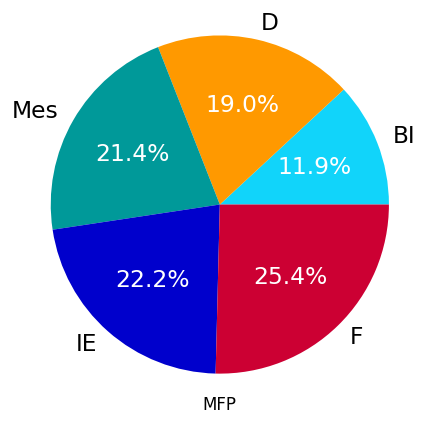

In [24]:
tme_predicted = MODEL.predict(proc_sc[used_processes]).rename('MFP')

# Vector Pie-plot
vector_pie_plot(tme_predicted, palette=portrait_palette)

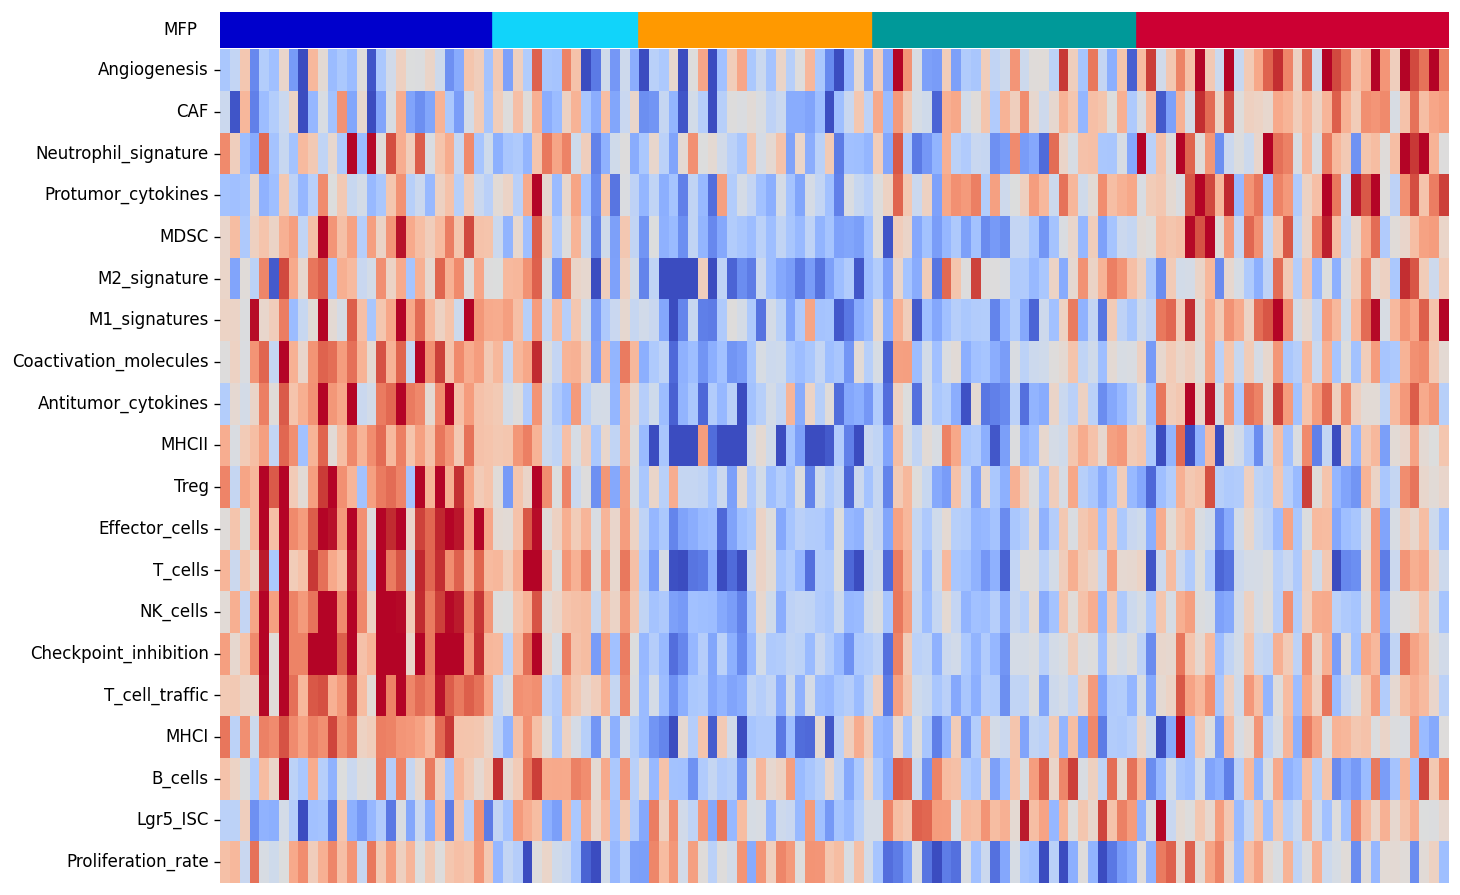

In [26]:
so = sort_by_terms_order(tme_predicted, portrait_order)

af = axis_matras([.3, 7], x_len=12)

ax = next(af)
line_palette_annotation_plot(tme_predicted[so], ax=ax, palette=portrait_palette)

ax = next(af)
# Heatmap of scaled signatures for taken dataset
sns.heatmap(proc_sc.loc[so, used_processes].T, vmin=-2, vmax=2,
            yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm, ax=ax)

plt.tight_layout(pad=.1)

# Denovo clustering

If you need reference cohort for classification you need to cluster your data

We will use processes calculated on TCGA cohort as an example

In [28]:
cluster_ann = meta_ann[meta_ann['Cohort'].isin(['TCGA', 'ACRG'])]

In [29]:
cluster_proc = meta_processes.loc[cluster_ann.index]
cluster_proc = cluster_proc[used_processes].clip(-2, 2)

100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


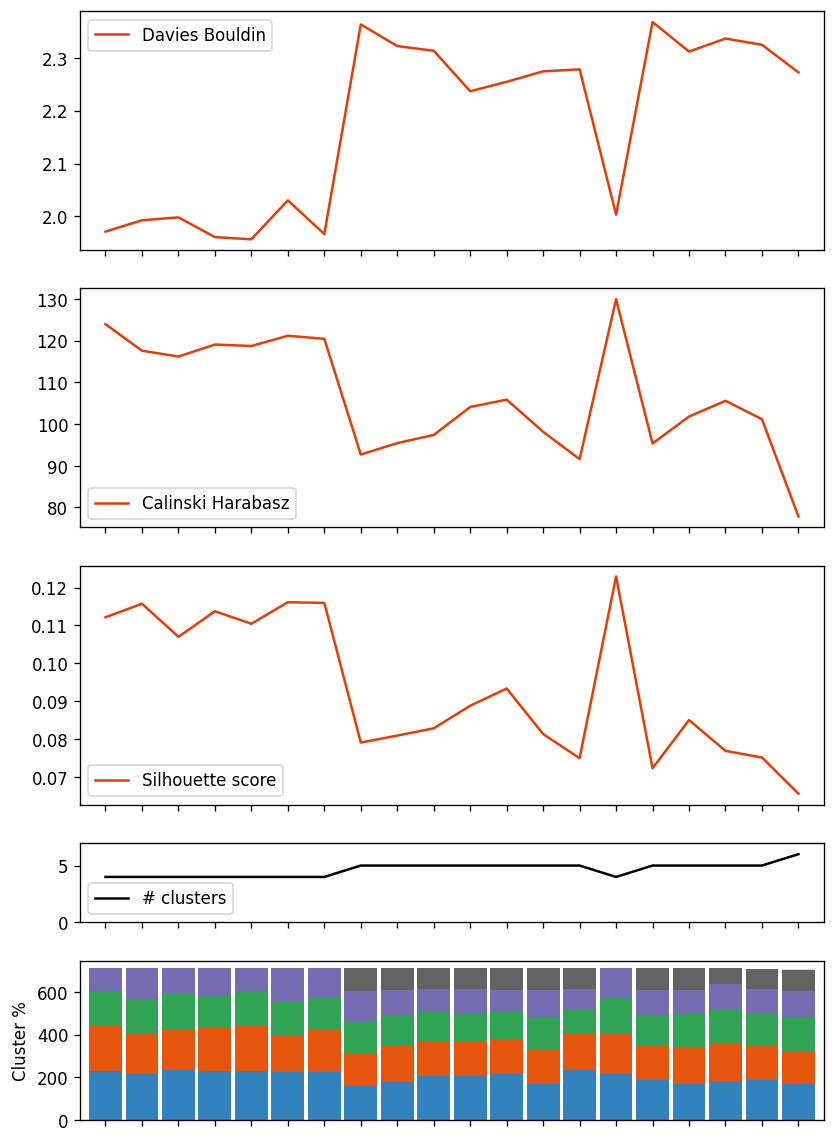

'0.51'

In [30]:
clustering_select_best_tr(cluster_proc, n_clusters=5, threshold_mm=(0.4, 0.6), step=0.01)

In [34]:
clusters = dense_clustering(cluster_proc, threshold=.51)

Calculating clusters means to identify TME subtypes

In [70]:
cluster_means = pd.DataFrame({cluster: cluster_proc.loc[clusters[clusters == cluster].index].mean()
                                  for cluster in range(1, 6)})

In [71]:
mapper = {}

mean = cluster_means.loc[['Angiogenesis', 'CAF']].mean().sort_values()
mapper[mean.index[-1]] = 'F'  # The cluster with the highest fibrose value is classified as Fibrotic
cluster_means.pop(mean.index[-1])

mean = cluster_means.loc[['B_cells']].mean().sort_values()
mapper[mean.index[-1]] = 'BI'  # The cluster with the highest B cell value is classified as B cell Infiltrated
cluster_means.pop(mean.index[-1])

mean = cluster_means.loc[['MHCII', 'Antitumor_cytokines', 'Coactivation_molecules',
                          'NK_cells', 'Checkpoint_inhibition',
                          'Effector_cells', 'T_cells',
                          'T_cell_traffic', 'MHCI']].mean().sort_values()
mapper[mean.index[-1]] = 'IE'  # The cluster with the level of immune cells is classified as Immune Enriched
cluster_means.pop(mean.index[-1])

deltas = (cluster_means.loc[['Angiogenesis', 'CAF',
                             'Protumor_cytokines', 'Neutrophil_signature','MDSC',
                             'Treg', 'M1_signatures', 'MHCII',
                             'Antitumor_cytokines', 'Coactivation_molecules', 'B_cells', 'NK_cells',
                             'Checkpoint_inhibition', 'Effector_cells', 'T_cells',
                             'T_cell_traffic', 'MHCI']].mean() -
              cluster_means.loc['Proliferation_rate']).sort_values()

mapper[deltas.index[0]] = 'D'  # The cluster with the highest proliferation value 
                                   # is classified as Immune Depleted

mapper[deltas.index[-1]] = 'Mes'  # Every sample not falling into the above-mentioned 
                                       # categories is classified as Mesenchymal

In [72]:
clustered_tme = clusters.map(mapper)

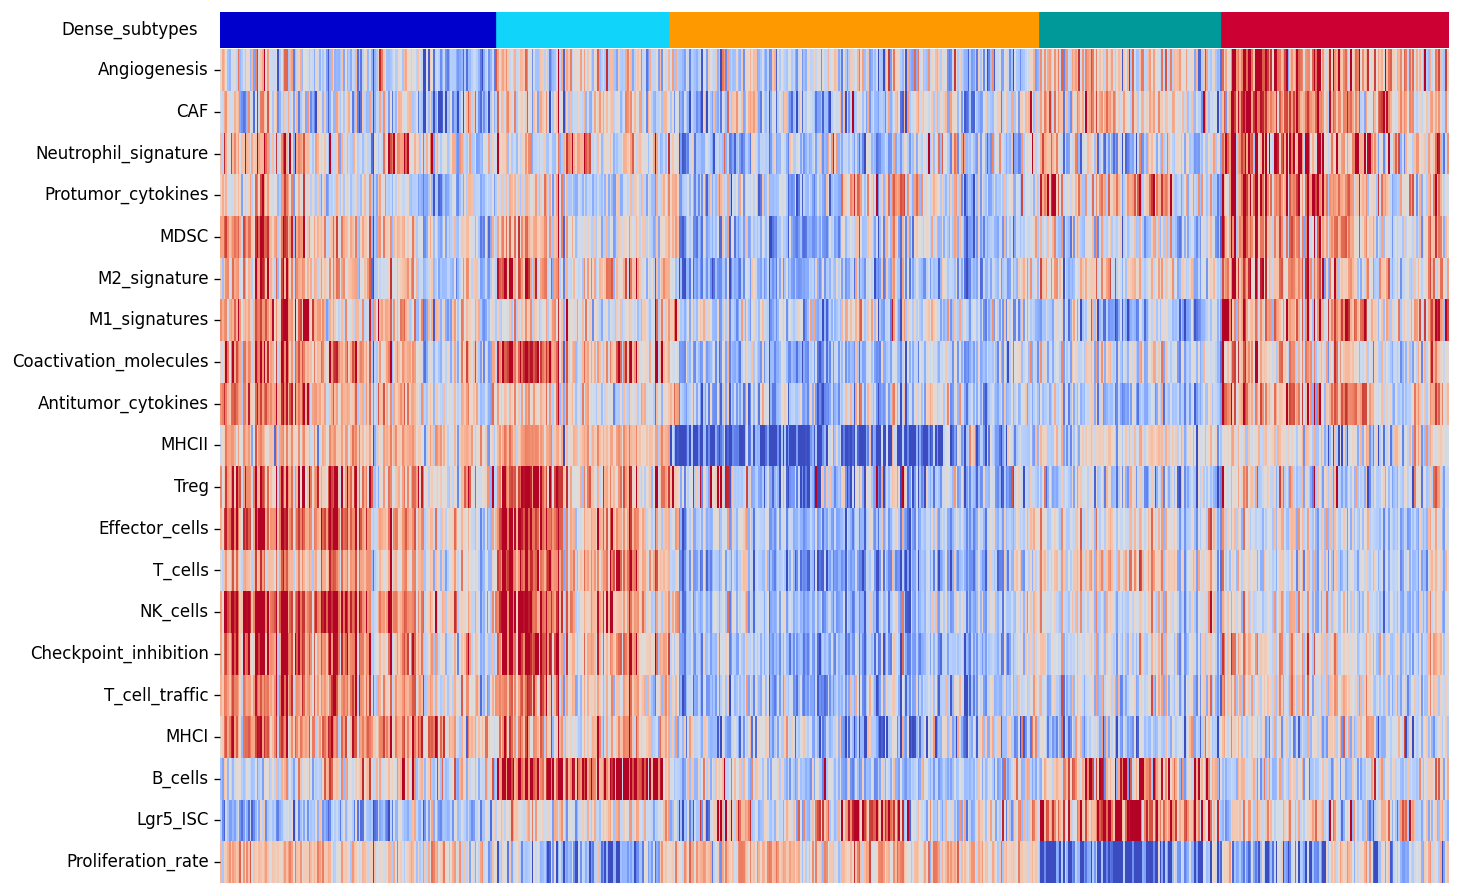

In [73]:
so = sort_by_terms_order(clustered_tme, portrait_order)

af = axis_matras([.3, 7], x_len=12)

ax = next(af)
line_palette_annotation_plot(clustered_tme[so], ax=ax, palette=portrait_palette)

ax = next(af)
# Heatmap of scaled signatures for taken dataset
sns.heatmap(cluster_proc.loc[so, used_processes].T, vmin=-2, vmax=2,
            yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm, ax=ax)

plt.tight_layout(pad=.1)